Couche de Convolution

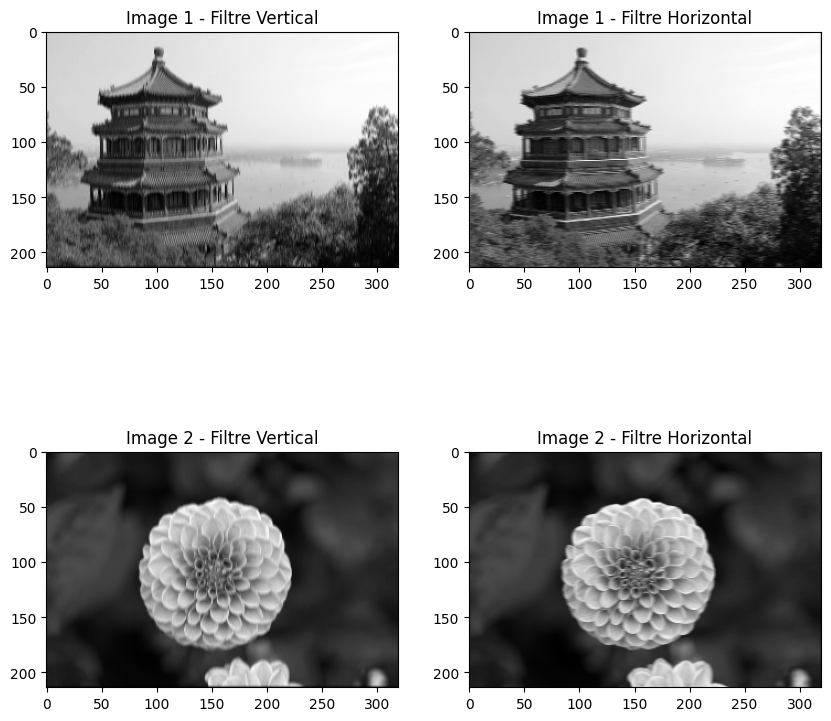

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

# On commence par charger les images
dataset = load_sample_images()  # dataset is a Bunch object
flower = dataset.images[0]
china = dataset.images[1]

# On definit notre dataset
dataset = np.array([flower, china], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

# On definit 2 filtres
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32) # channel represente le nombre de canaux de l'image
filters[:, 3, :, 0] = 1 # ligne verticale
filters[3, :, :, 1] = 1 # ligne horizontale

# On applique les filtres sur X avec la fonction conv2d
X = tf.constant(dataset, dtype=tf.float32)
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

# On run la fonction convolution sur notre dataset
output = convolution.numpy()

# On affiche les resultats
plt.figure(figsize=(10, 10))

# Image 1 - Filtre Vertical
plt.subplot(2, 2, 1)
plt.imshow(output[0, :, :, 0], cmap="gray")
plt.title('Image 1 - Filtre Vertical')

# Image 1 - Filtre Horizontal
plt.subplot(2, 2, 2)
plt.imshow(output[0, :, :, 1], cmap="gray")
plt.title('Image 1 - Filtre Horizontal')

# Image 2 - Filtre Vertical
plt.subplot(2, 2, 3)
plt.imshow(output[1, :, :, 0], cmap="gray")
plt.title('Image 2 - Filtre Vertical')

# Image 2 - Filtre Horizontal
plt.subplot(2, 2, 4)
plt.imshow(output[1, :, :, 1], cmap="gray")
plt.title('Image 2 - Filtre Horizontal')

plt.show()

Couche de pooling

Text(0.5, 1.0, 'Max Pooling')

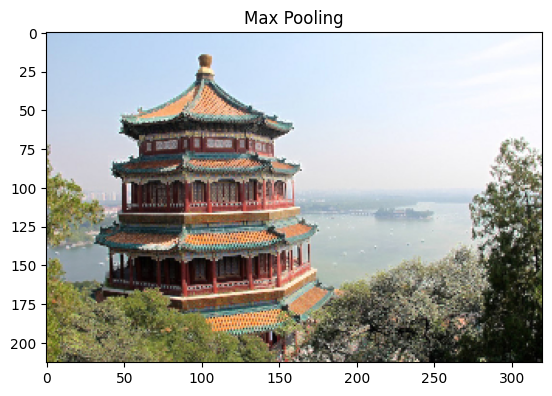

In [13]:
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")
output = max_pool.numpy()

plt.imshow(output[0].astype(np.uint8))
plt.title('Max Pooling')

Classification d'images avec Inception V3

In [ ]:
# Téléchargement d'une image test
import os
import urllib.request

width = 299
height = 299
channels = 3

images_path = os.path.join("images", "cnn")
os.makedirs(images_path, exist_ok=True)
Download_root = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "test_image.png"
print("Downloading", filename)
url = Download_root + "images/cnn/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('images/cnn/test_image.png', <http.client.HTTPMessage at 0x7f602ade34c0>)

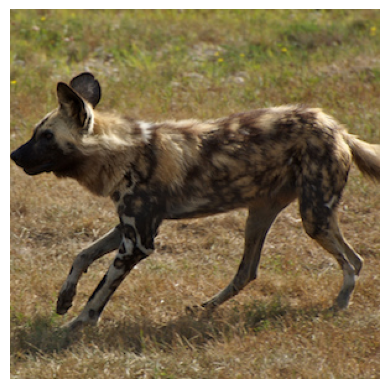

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

test_image = mpimg.imread(os.path.join("images","cnn","test_image.png"))[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

In [34]:
# On s'assure que les valeurs de l'image sont comprises dans [-1;1]
test_image = 2 * test_image - 1

In [17]:
# Téléchargement d'Inception v3
import sys
import tarfile
import urllib.request

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [18]:
fetch_pretrained_inception_v3()

Downloading: 100%

In [19]:
# Téléchargement du datasets
images_path = os.path.join("datasets", "inception")
os.makedirs(images_path, exist_ok=True)
Download_root = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "imagenet_class_names.txt"
print("Downloading", filename)
url = Download_root + "datasets/inception/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('datasets/inception/imagenet_class_names.txt',
 <http.client.HTTPMessage at 0x7f602a79f7f0>)

In [22]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    path = os.path.join("datasets", "inception", "imagenet_class_names.txt")
    with open(path, encoding="utf-8") as f:
        content = f.read()
        return CLASS_NAME_REGEX.findall(content)

In [23]:
class_names = ["background"] + load_class_names()

In [25]:
# Entraînement d'Inception

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Model

# Load the InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=True)

# Define the model
X = base_model.input
predictions = base_model.output

# Create a new model
model = Model(inputs=X, outputs=predictions)

96112376/96112376 [==============================] - 15s 0us/step


In [36]:
# Prédiction de notre image test
import numpy as np

X_test = test_image.reshape(-1, height, width, channels)
predictions_val = model.predict(X_test)
top_5 = np.argsort(predictions_val[0])[-5:][::-1]

for i in top_5:
    print(f"{class_names[i]}: {predictions_val[0][i]:.2f}")

1/1 [==============================] - 0s 207ms/step
dhole, Cuon alpinus: 0.93
African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus: 0.03
great grey owl, great gray owl, Strix nebulosa: 0.00
beaker: 0.00
sweatshirt: 0.00


In [37]:
# Le modèle est très confiant sur sa prédiction